In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

/home/norm/hoai_workspace/hoai_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
cars_df = pd.read_csv("../data/cars/cars_dataset.csv", sep = "\t", encoding='utf-8')

# Chuyển đổi dữ liệu từ dữ liệu thô

In [3]:
num_cols = ['price', 'length', 'height', 'width', 'weight', 'weightTotal', 'emissionsCO2', 'numberOfAxles',
            'numberOfDoors', 'numberOfForwardGears', 'seatingCapacity', 'cargoVolume', 'roofLoad', 
            'accelerationTime', 'fuelCapacity', 'fuelConsumption', 'speed', 'payload', 'trailerWeight', 
            'vEengineDisplacement', 'vEenginePower', 'torque']

In [4]:
cat_cols = []
for col in cars_df.columns:
    if not (col in num_cols):
        cat_cols.append(col)

In [5]:
print(len(num_cols), len(cat_cols))
print(num_cols, '\n', cat_cols)

22 12
['price', 'length', 'height', 'width', 'weight', 'weightTotal', 'emissionsCO2', 'numberOfAxles', 'numberOfDoors', 'numberOfForwardGears', 'seatingCapacity', 'cargoVolume', 'roofLoad', 'accelerationTime', 'fuelCapacity', 'fuelConsumption', 'speed', 'payload', 'trailerWeight', 'vEengineDisplacement', 'vEenginePower', 'torque'] 
 ['url', 'name', 'model', 'brand', 'eLabel', 'bodyType', 'modelDate', 'fuelType', 'vehicleTransmission', 'driveWheelConfiguration', 'vEengineType', 'vEfuelType']


### Xử lý các cột dữ liệu số

In [ ]:
# copy ra df để xư lý
df = cars_df.copy()

In [ ]:
# fucntion convert cac thuoc tinh khac
def cvtFloat(x):
    if type(x) == str:
        temp = x.replace(',', '.').split()[0]
    else:
        temp = x
    val = None
    try:
        val = float(temp)
    except ValueError:
        return val
    return val

In [ ]:
for el in num_cols:
    if el != 'cargoVolume':
        print(el)
        df[el] = df[el].apply(cvtFloat)

In [ ]:
# Hàm xử lý riêng cho cargoVolume
def cvtFloat_cargoVolume(x):
    temp = x.split()[0]
    temp = temp.replace('-', ' ')
    temp = temp.split()
    if len(temp) > 0:
        temp = temp[-1]
    else:
        temp = x
    val = None
    try:
        val = float(temp)
    except ValueError:
        return val
    return val

In [ ]:
df['cargoVolume'] = df['cargoVolume'].apply(cvtFloat_cargoVolume)

In [ ]:
df[num_cols].info()

### Xử lý các cột dữ liệu categorize

In [ ]:
for cat in cat_cols[:]:
    print(cat, len(cars_df[cat].unique()))

* Có thể loại bỏ cột vehicleTransmission vì chỉ có 1 giá trị, không có ý nghĩa trong việc học.
* Cột fuelType và vEfuelType là giống nhau (do quá trình crawl nhóm không để ý), có thể drop cột fuelType.
* Các cột url, name, model có nhiều ý nghĩa, nên có thể loại bỏ.
* brand có thể xét vì có tới 89 giá trị (có khả năng sẽ có ý nghĩa với các brand có giá trị cao), modelDate cần xem xét.

**=> Số cột còn lại là: eLabel (9), bodyType (11), driveWheelConfiguration (6), vEengineType (4), vEfuelType (11).**

In [ ]:
# chuẩn hóa cột modelDate
def norm_modelDate(x):
    if (x == 0):
        return None
    else:
        return str(x)
df['modelDate'] = df['modelDate'].apply(norm_modelDate)
df['modelDate'].unique()

In [ ]:
df['driveWheelConfiguration'].unique()

In [ ]:
df['bodyType'].unique()

In [ ]:
df['eLabel'].unique()

In [ ]:
df['vEengineType'].unique()

In [ ]:
df['vEfuelType'].unique()

* Cột driveWheelConfiguration không có giá trị lỗi ('N.A.', '-', ...)
* Các cột bodyType, vEengineType, vEfuelType có chứa nan (đã được xử lý).
* Cột eLabel có chứa các giá trị lỗi, cần được chuẩn hóa. Sau khi chuẩn hóa, dòng thiếu dữ liệu quá nhiều nên cần loại bỏ khi qua bước xử lý.

In [ ]:
def norm_eLabel(x):
    if (x == 'N.A.' or x == '-'):
        return None
    else:
        return x

In [ ]:
df['eLabel'] = df['eLabel'].apply(norm_eLabel)

In [ ]:
df[cat_cols].info()

### Lưu ra file để tiện xử lý

In [ ]:
# df.to_csv("cars_preprocessed_undrop.csv", sep = "\t", index=False, encoding='utf-8')

# Tiền xử lý dữ liệu và huấn luyện

In [6]:
df_ori = pd.read_csv("../data/cars/train_data.csv", sep = "\t", encoding='utf-8')

In [7]:
df = df_ori.copy()
draw_df = df_ori.copy()

In [8]:
num_cols = ['length','height','width','weight','emissionsCO2','numberOfAxles',
            'numberOfDoors','numberOfForwardGears','seatingCapacity','cargoVolume','roofLoad',
            'accelerationTime','fuelCapacity','fuelConsumption','speed',
            'payload','trailerWeight','vEengineDisplacement','vEenginePower','torque']
for col in num_cols:
    draw_df[col] = draw_df[col].apply(lambda x: draw_df[col].mean() if str(x) == 'nan' else x)

/home/norm/hoai_workspace/hoai_env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/norm/hoai_workspace/hoai_env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


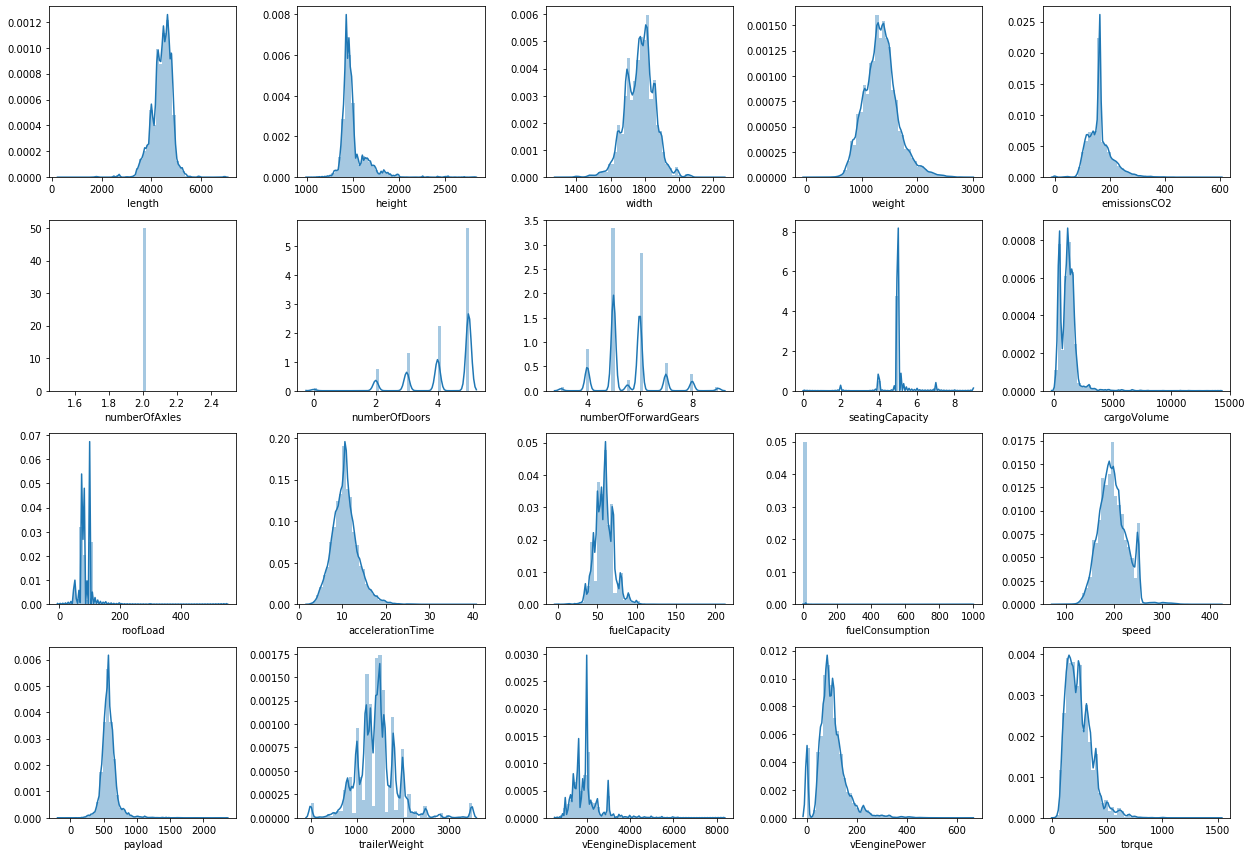

In [62]:
nr_rows = 4
nr_cols = 5

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(num_cols):
            sns.distplot(draw_df[num_cols[i]], ax = axs[r][c])
            # sns.regplot(draw_df[num_cols[i]], draw_df['price'], ax = axs[r][c])
            # stp = stats.pearsonr(draw_df[num_cols[i]], draw_df['price'])
            # axs[r][c].text(0.4,0.9,"title",fontsize=7)
            # str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            # axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

/home/norm/hoai_workspace/hoai_env/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


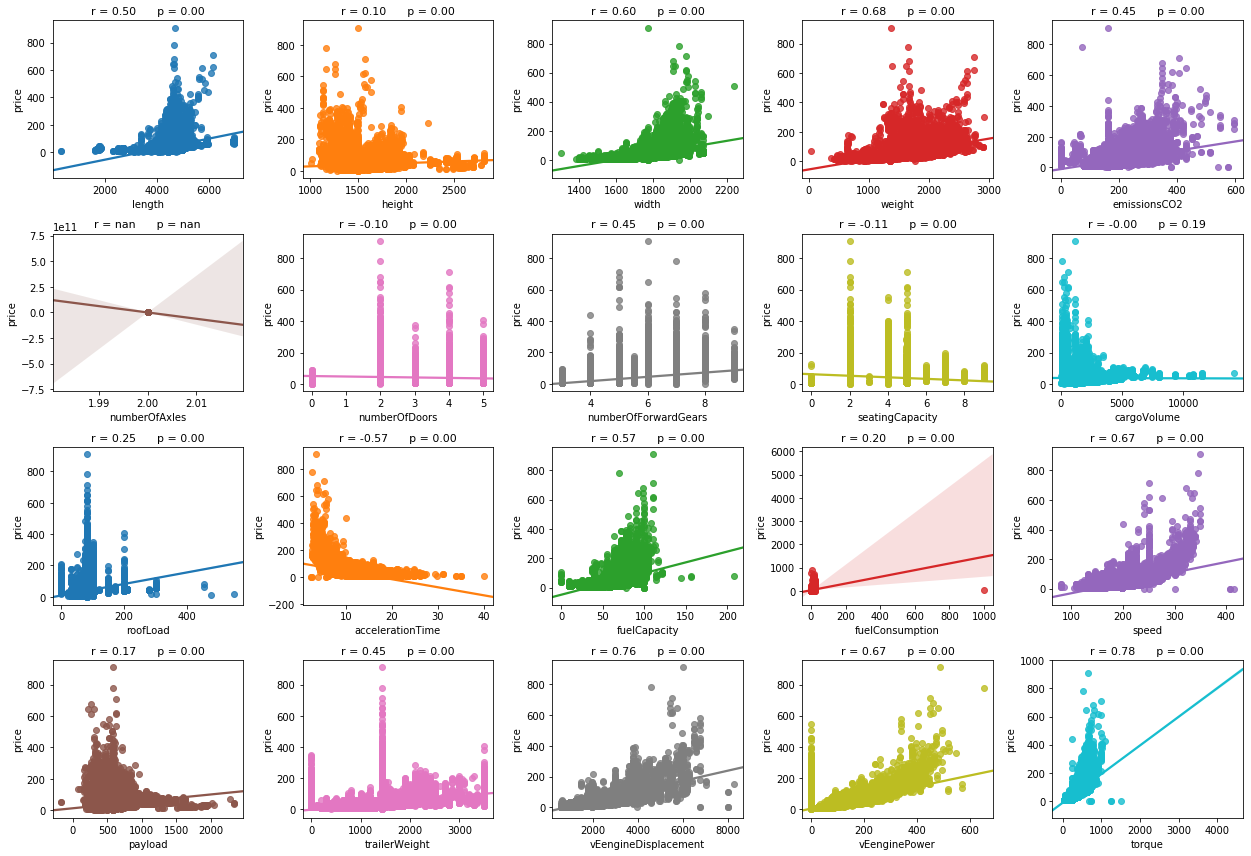

In [9]:
nr_rows = 4
nr_cols = 5

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(num_cols):
            sns.regplot(draw_df[num_cols[i]], draw_df['price'], ax = axs[r][c])
            stp = stats.pearsonr(draw_df[num_cols[i]], draw_df['price'])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

In [25]:
num_col_to_remove = ['height', 'numberOfAxles', 'numberOfDoors', 'seatingCapacity', 'cargoVolume',
                    'accelerationTime']
[num_cols.remove(x) for x in num_col_to_remove]

[None, None, None, None, None, None]

In [27]:
len(num_cols)

14

In [28]:
y = df['price']
X = df.drop(['price'], axis = 1)

In [29]:
# origin copy
X_ori = X.copy()
y_ori = y.copy()

In [30]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
len(train_X), len(val_X)

(60472, 15118)

## Tạo pipeline và build model

### Functions

#### Multilabel Encoding

In [14]:
def f(x, l):
    if type(x) is list:
        l.update(x)
class MultilabelEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name
        self.type_list = set()
    def fit(self, X_df, y=None):
        types_sr = X_df[self.col_name].str.replace('[/+]', ' ').str.split()
        types_sr.apply(f, args=(self.type_list,))
        self.type_list = list(self.type_list)
        return self
    def transform(self, X_df, y=None):
        transformed_df = X_df.copy()
        for i in range(len(self.type_list)):
            transformed_df[self.col_name + '_' + self.type_list[i]] = transformed_df[self.col_name].apply(lambda x: 1 if ((type(x) is str) and (self.type_list[i] in x)) else 0)
        transformed_df.drop(self.col_name, axis=1, inplace=True)
        return transformed_df

#### col add and drop

In [15]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_brands = 10):
        # TODO
        self.num_top_brands = num_top_brands
        self.dropped_cols = ['url', 'name', 'model', 'weightTotal', 'fuelType', 'vehicleTransmission', 'modelDate']
    def fit(self, X_df, y=None):
        brand_col = X_df.brand.str.extract(r'([a-zA-z]+)', expand=False)
        self.brand_counts_ = brand_col.value_counts()
        brands = list(self.brand_counts_.index)
        self.top_brands_ = brands[:max(1, min(self.num_top_brands, len(brands)))]
        return self
    def transform(self, X_df, y=None):
        df = X_df.copy()
        brand_col = df.brand.str.extract("([a-zA-z]+)", expand=False)
        brand_col[~brand_col.isin(self.top_brands_)] = 'Others'
        df["brand"] = brand_col
        df.drop(self.dropped_cols, axis=1, inplace=True)
        return df

In [32]:
cat_multi = ['vEfuelType', 'driveWheelConfiguration']
cat_single = ['brand', 'eLabel', 'bodyType', 'vEengineType']

In [33]:
col_adderdropper = ColAdderDropper()

In [34]:
num_cols = []
for col in X.columns:
    if (not col in cat_single) and (not col in cat_multi) and (not col in col_adderdropper.dropped_cols):
        num_cols.append(col)

In [35]:
len(num_cols), len(cat_single), len(cat_multi)

(20, 4, 2)

#### Hàm train và validate model

In [36]:
def train_and_val(full_pipeline, train_X, train_y, val_X, val_y):
    full_pipeline.fit(train_X, train_y);
    #print("n_brands:", len(col_adderdropper.top_brands_))
    pred_y = full_pipeline.predict(val_X)
    train_score = full_pipeline.score(train_X, train_y)
    val_score = full_pipeline.score(val_X, val_y)
    print(train_score, val_score)
    print("MSE =", np.round(np.mean((pred_y - val_y) ** 2), 3))
    print("MAE =", np.round(np.mean(np.abs(pred_y - val_y)), 3))
    return train_score, val_score

### các pipeline cần thiết cho pipeline cho preprocessing

In [37]:
imp_mean = SimpleImputer(strategy='mean') 
imp_mode = SimpleImputer(strategy='most_frequent')

encoding = OneHotEncoder(handle_unknown='ignore', sparse=False)
vEfuelType_encoder = MultilabelEncoding('vEfuelType')
driveWheelConfig_encoder = MultilabelEncoding('driveWheelConfiguration')

categorical_transformer = make_pipeline(imp_mode, encoding)

colTransform = ColumnTransformer(transformers=[('numerical', imp_mean, num_cols),\
                                               ('categorical', categorical_transformer, cat_single),
                                               ('vEfuelType', vEfuelType_encoder, ['vEfuelType']),
                                               ('driveWheelConfig', driveWheelConfig_encoder, ['driveWheelConfiguration'])])

colNormalize = StandardScaler()

#preprocessing = make_pipeline(col_adderdropper, colTransform, colNormalize)

### Full pipeline với MLPRegressor

In [38]:
mlpregressor = MLPRegressor(hidden_layer_sizes=(512, 512, ), solver='adam', learning_rate='adaptive'\
                            ,random_state=0, max_iter=500, early_stopping=True, verbose=1)

# preprocessing.set_params(coladderdropper__num_top_brands = 100)

full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, mlpregressor)

full_pipeline.set_params(coladderdropper__num_top_brands = 100)

train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

Iteration 1, loss = 118.24759786
Validation score: 0.917690
Iteration 2, loss = 51.31375839
Validation score: 0.926715
Iteration 3, loss = 41.05958683
Validation score: 0.917320
Iteration 4, loss = 40.49465813
Validation score: 0.943670
Iteration 5, loss = 37.72652620
Validation score: 0.931685
Iteration 6, loss = 35.93957426
Validation score: 0.942864
Iteration 7, loss = 32.41161494
Validation score: 0.950620
Iteration 8, loss = 30.39782635
Validation score: 0.949409
Iteration 9, loss = 30.33328801
Validation score: 0.898011
Iteration 10, loss = 29.32511922
Validation score: 0.957898
Iteration 11, loss = 26.04192713
Validation score: 0.945170
Iteration 12, loss = 25.25259162
Validation score: 0.957446
Iteration 13, loss = 22.71634071
Validation score: 0.958129
Iteration 14, loss = 21.69556350
Validation score: 0.932275
Iteration 15, loss = 24.44107160
Validation score: 0.961585
Iteration 16, loss = 19.76766278
Validation score: 0.963715
Iteration 17, loss = 18.13711562
Validation scor

(0.9765448015005836, 0.5773938980185629)

#### model (512, 256, 512)

In [39]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(512, 256, 512, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9767729132366367 0.7809908292794265
MSE = 198.426
MAE = 3.041


(0.9767729132366367, 0.7809908292794265)

#### model (256, 256, 256)

In [40]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 256, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9658557167591614 0.7154264989941668
MSE = 257.829
MAE = 3.015


(0.9658557167591614, 0.7154264989941668)

#### model (256, 512, 256)

In [ ]:
full_pipeline.set_params(mlpregressor__verbose=1, mlpregressor__hidden_layer_sizes=(256, 512, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

#### model (256, 512, 512, 256)

In [57]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9469180582378245 0.8917373042694016
MSE = 98.088
MAE = 3.41


(0.9469180582378245, 0.8917373042694016)

#### model (256, 512, 512, 256, 128)

In [58]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 256, 128, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.968874482026066 0.8829205161438752
MSE = 106.076
MAE = 3.27


(0.968874482026066, 0.8829205161438752)

#### model (256, 512, 512, 512, 256)

In [62]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 512, 256, ))
print('...')
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

...
0.9739361561697789 0.8771331410776515
MSE = 111.32
MAE = 2.858


(0.9739361561697789, 0.8771331410776515)

In [16]:
# mlpregressor = MLPRegressor(hidden_layer_sizes=(16, 32, 64, 64, 32, 16, ), solver='adam', learning_rate='adaptive'\
#                             ,random_state=0, max_iter=500, early_stopping=True, verbose=0)
# full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, mlpregressor)

#### Chọn model (256, 512, 512, 256) đạt val cao nhất ở trên

In [ ]:
full_pipeline.set_params(mlpregressor__verbose=0, mlpregressor__hidden_layer_sizes=(256, 512, 512, 256, ))
nn_train_scores, nn_val_scores = [], []
best_n_brands, nn_best_val_score = 10, -float('inf')
for n_brands in range(5, 95, 5):
    print('...')
    full_pipeline.set_params(coladderdropper__num_top_brands=n_brands)
    train_score, val_score = train_and_val(full_pipeline, train_X, train_y, val_X, val_y)
    if (nn_best_val_score < val_score):
        nn_best_val_score = val_score
        best_n_brands = n_brands
    nn_train_scores.append(train_score)
    nn_val_scores.append(val_score)
    print()
'Finish!'

In [43]:
best_n_brands, nn_best_val_score

(35, 0.7115401310299664)

#### train model với số lượng brands tốt nhất tìm được

In [44]:
best_n_brands = 80

In [45]:
full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, mlpregressor)
full_pipeline.set_params(coladderdropper__num_top_brands=best_n_brands, mlpregressor__verbose=1)
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

Iteration 1, loss = 108.63671771
Validation score: 0.913704
Iteration 2, loss = 49.91500242
Validation score: 0.928836
Iteration 3, loss = 42.09434270
Validation score: 0.917708
Iteration 4, loss = 37.15814983
Validation score: 0.910634
Iteration 5, loss = 33.86957128
Validation score: 0.928931
Iteration 6, loss = 31.52308653
Validation score: 0.944980
Iteration 7, loss = 32.37350409
Validation score: 0.953067
Iteration 8, loss = 31.04202452
Validation score: 0.947602
Iteration 9, loss = 26.55773373
Validation score: 0.935912
Iteration 10, loss = 24.41084961
Validation score: 0.941615
Iteration 11, loss = 21.75910159
Validation score: 0.948736
Iteration 12, loss = 22.83886398
Validation score: 0.950168
Iteration 13, loss = 21.71920903
Validation score: 0.958626
Iteration 14, loss = 21.86723934
Validation score: 0.963423
Iteration 15, loss = 19.43619724
Validation score: 0.954558
Iteration 16, loss = 17.49588533
Validation score: 0.957098
Iteration 17, loss = 15.83410043
Validation scor

(0.973745795075807, 0.834481571137383)

#### save model

In [74]:
# joblib.dump(full_pipeline, 'nn_80.pkl')

['nn_80.pkl']

### full pipeline với RandomForestRegressor

In [46]:
rfregressor = RandomForestRegressor(n_estimators=1, random_state=0, verbose=1)
full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, rfregressor)
full_pipeline.set_params(coladderdropper__num_top_brands = 80);

In [47]:
full_pipeline.set_params(randomforestregressor__verbose = 0)
rf_train_scores, rf_val_scores = [], []
best_n_estimators, best_val_score = 1, -float('inf')
n_estimators = 1
while (n_estimators < 2048):
    print('n_estimators: ',n_estimators)
    full_pipeline.set_params(randomforestregressor__n_estimators = n_estimators)
    train_score, val_score = train_and_val(full_pipeline, train_X, train_y, val_X, val_y)
    rf_train_scores.append(train_score)
    rf_val_scores.append(val_score)
    if best_val_score < val_score:
        best_val_score, best_n_estimators = val_score, n_estimators
    n_estimators *= 2
    print()

n_estimators:  1
0.9738919641779549 0.9450200126278578
MSE = 49.813
MAE = 3.145

n_estimators:  2
0.9817050860850235 0.9611463324185997
MSE = 35.202
MAE = 2.877

n_estimators:  4
0.9857390998819424 0.9674476997831059
MSE = 29.493
MAE = 2.683

n_estimators:  8
0.9878203476992041 0.9739670974871707
MSE = 23.586
MAE = 2.55

n_estimators:  16
0.9903086318972296 0.9757221767412344
MSE = 21.996
MAE = 2.508

n_estimators:  32
0.9914733363799308 0.9760146926259691
MSE = 21.731
MAE = 2.48

n_estimators:  64
0.9917061112021445 0.9766277692944674
MSE = 21.176
MAE = 2.455

n_estimators:  128
0.9920212523286847 0.9767773617058559
MSE = 21.04
MAE = 2.449

n_estimators:  256
0.9921273271497626 0.9767909200679659
MSE = 21.028
MAE = 2.445

n_estimators:  512
0.9920665251225336 0.9765602538380559
MSE = 21.237
MAE = 2.446

n_estimators:  1024
0.9921372079867443 0.9766354075851928
MSE = 21.169
MAE = 2.444



In [65]:
rfregressor = RandomForestRegressor(n_estimators=1024, random_state=0, verbose=1)
full_pipeline = make_pipeline(col_adderdropper, colTransform, colNormalize, rfregressor)
full_pipeline.set_params(coladderdropper__num_top_brands = 90)
train_and_val(full_pipeline, train_X, train_y, val_X, val_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed: 30.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  8.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1024 out of 1024 | elapsed:  6.6min finished


0.9921103998585453 0.9766075892992062
MSE = 21.194
MAE = 2.443


(0.9921103998585453, 0.9766075892992062)

In [71]:
# save model
# joblib.dump(full_pipeline, 'rf_1024.pkl')

['rf_1024.pkl']

# Testing

In [ ]:
#full_pipeline.set_params(mlpregressor__alpha=best_alpha)
pred_y = full_pipeline.predict(test_X)

In [ ]:
pred_y

In [ ]:
np.array(test_y)

In [ ]:
np.mean(np.abs(pred_y - test_y))

In [ ]:
np.mean(np.abs(pred_y - test_y))

In [ ]:
np.mean((pred_y - test_y) ** 2)

In [ ]:
np.mean((pred_y - test_y) ** 2)